# 第三次课堂实验

在这次实验中，我们将尝试提取基本的图像特征并使用提取的特征进行图像分类。

你可以添加任意数量的 cell 来辅助你完成实验（方法：上方菜单栏 -> File -> Insert -> Insert Cell Above/Below）。

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15., 12.) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## 数据加载

你需要把 cifar10-mini 数据集文件放到指定的路径，或者直接修改代码中的路径。理解该数据集的类型以及访问方式

In [4]:
# 读取提供的cifar10-mini数据集，
data = np.load('cifar10-mini.npz')

X_train= data['X_train']
X_val= data['X_val']
X_test= data['X_test']
y_train= data['y_train']
y_val= data['y_val']
y_test= data['y_test']

#np.savez_compressed('cifar10-mini.npz',X_train=X_train,X_val=X_val,X_test=X_test,y_train=y_train,y_val=y_val,y_test=y_test )
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(5000, 32, 32, 3)
(500, 32, 32, 3)
(500, 32, 32, 3)


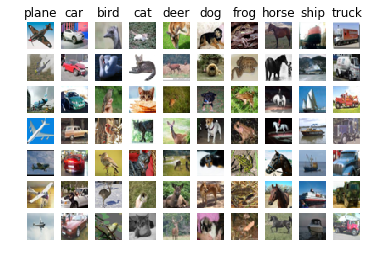

In [5]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()


## 提取图像特征
[方向梯度直方图 HOG (Histogram of Oriented Gridients)](http://blog.csdn.net/zouxy09/article/details/7929348)特征检测算法，最早是由法国研究员Dalal等在CVPR-2005上提出来的，一种解决人体目标检测的图像描述子，是一种用于表征图像局部梯度方向和梯度强度分布特性的描述符。其主要思想是：在边缘具体位置未知的情况下，边缘方向的分布也可以很好的表示图像中物体的外形轮廓，但会忽略掉颜色信息。特征维度是144维

[颜色直方图 (color histogram)](https://baike.baidu.com/item/颜色直方图)特征则是提取图像的颜色信息并忽略掉纹理信息。因此同时使用这两种特征的分类效果会好于仅使用单一特征，__【加分项】你可以尝试进行对比实验验证这一假设__

`hog_feature` 和 `color_histogram_hsv` 两个函数都是接收一张图像然后返回这张图像的特征向量。你可以使用这两个函数中的一个提取所有图像的特征并将其存入 `X_train_feats, X_val_feats, X_test_feats` 这三个变量中（他们分别代表训练集、验证集和测试集的特征）。

如果你遇到了错误 `ImportError: No module named past.builtins`，可以在命令行工具中执行 `pip install future`

In [4]:
from features import *

################################################################################
# TODO:                                                                        #
# 你需要使用 hog_feature, color_histogram_hsv 两个函数完成特征的提取                #
# 你可以在 features.py 中查看这两个函数的代码                                       #
################################################################################
# 你的代码

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

X_train_feats = None
X_val_feats = None
X_test_feats = None

#你的代码， 进行特征提取 

#同时使用两种方法提取特征,最后结果为0.314
num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

#不提取特征的方法,最后结果为0.29
#X_train_feats = np.reshape(X_train, (X_train.shape[0], -1))
#X_val_feats = np.reshape(X_val, (X_val.shape[0], -1))
#X_test_feats = np.reshape(X_test, (X_test.shape[0], -1))

#只使用hog提取特征，结果为0.288
#num_color_bins = 10 # Number of bins in the color histogram
#feature_fns = [hog_feature]
#X_train_feats = extract_features(X_train, feature_fns, verbose=True)
#X_val_feats = extract_features(X_val, feature_fns)
#X_test_feats = extract_features(X_test, feature_fns)

#只使用hsv提取特征，结果为0.214
#num_color_bins = 10 # Number of bins in the color histogram
#feature_fns = [lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
#X_train_feats = extract_features(X_train, feature_fns, verbose=True)
#X_val_feats = extract_features(X_val, feature_fns)
#X_test_feats = extract_features(X_test, feature_fns)

print(X_train_feats.shape,X_val_feats.shape, X_test_feats.shape)
    
# 预处理: 减去均值

mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# 预处理: 除以标准差，这能保证所有的值在 0～1 之间
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat
    
# 预处理: 增加一个偏置值，在 K-NN 中，该步操作并无必要，但增加偏置值对其他分类器如 SVM 等有帮助。
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])


Done extracting features for 1000 / 5000 images
Done extracting features for 2000 / 5000 images
Done extracting features for 3000 / 5000 images
Done extracting features for 4000 / 5000 images
(5000, 154) (500, 154) (500, 154)


## 使用 k-NN 算法对图像进行分类

使用上面提取的特征执行 k-NN 算法对图像分类，在这里，__【加分项】你也可以实验使用 HOG／颜色直方图特征与使用图像原始特征（像素）哪个好。或者尝试特征拼接

这里你需要补全`k_nearest_neighbor.py`中的部分关键函数的代码，包括`compute_distances_one_loop`,`compute_distances_two_loop`,`compute_distances_no_loop`和`predict_labels`


你可能需要认真阅读玩下面两篇文章后才能完成这部分作业：

- [CS231n课程笔记翻译：图像分类笔记（上）](https://zhuanlan.zhihu.com/p/20894041?refer=intelligentunit)
- [CS231n课程笔记翻译：图像分类笔记（下）](https://zhuanlan.zhihu.com/p/20900216?refer=intelligentunit)

In [5]:
from k_nearest_neighbor import KNearestNeighbor

classifier = KNearestNeighbor()
classifier.train(X_train_feats, y_train)

In [6]:
from k_nearest_neighbor import KNearestNeighbor

classifier = KNearestNeighbor()
classifier.train(X_train_feats, y_train)
# 使用验证集调整 k 的值

k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]
k_to_accuracies = {} # your should store the results in this dict

################################################################################
# TODO:                                                                        #
# 你需要从 k_choice 中找出最好的 k                                                #
#  如果accuracy <= 0.1， 说明结果不对，随机猜的准确率是0.1，需要修改k_nearest_neighbor.py       #
################################################################################
# 尝试使用不同实现方法下的距离计算函数，并比较他们的结果的一致性和计算速度
#经过比较，结果都是0.314
dists = classifier.compute_distances_no_loops(X_val_feats)
#dists = classifier.compute_distances_one_loop(X_val_feats)
#dists = classifier.compute_distances_two_loops(X_val_feats)

#遍历所有的k，在验证集上进行结果测试分类的准确性
num_test = 500
for k in k_choices:
    y_val_pre = classifier.predict_labels(dists, k=k)
    num_correct = np.sum(y_val_pre == y_val)
    accuracy = float(num_correct) / num_test
    #print ('Got %d / %d correct => accuracy: %f，k = %d' % (num_correct, num_test, accuracy,k))
    k_to_accuracies[k] = accuracy
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

for k in sorted(k_to_accuracies):
    print('k = %d, accuracy = %f' % (k, k_to_accuracies[k]))

k = 1, accuracy = 0.320000
k = 3, accuracy = 0.330000
k = 5, accuracy = 0.334000
k = 8, accuracy = 0.324000
k = 10, accuracy = 0.308000
k = 12, accuracy = 0.328000
k = 15, accuracy = 0.324000
k = 20, accuracy = 0.326000
k = 50, accuracy = 0.294000
k = 100, accuracy = 0.258000


In [7]:
#比较三种方式的运行速度
def time_function(f, *args):
  """
  Call a function f with args and return the time (in seconds) that it took to execute.
  """
  import time
  tic = time.time()
  f(*args)
  toc = time.time()
  return toc - tic
#Two loop version took 22.777799 seconds
two_loop_time = time_function(classifier.compute_distances_two_loops, X_test_feats)
print ('Two loop version took %f seconds' % two_loop_time)

#one loop version took 6.707191 seconds
one_loop_time = time_function(classifier.compute_distances_one_loop, X_test_feats)
print ('one loop version took %f seconds' % one_loop_time)

#no loop version took 0.165169 seconds
no_loop_time = time_function(classifier.compute_distances_no_loops, X_test_feats)
print ('no loop version took %f seconds' % no_loop_time)

Two loop version took 14.296709 seconds
one loop version took 4.840944 seconds
no loop version took 0.100688 seconds


In [8]:
# 评估你的算法

best_k = 5  # 填你上面选出的 K 值

# 计算测试集上准确率
y_test_pred = classifier.predict(X_test_feats, k=best_k)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.314
